# Neural Network mapping to learn MODIS LST from ERA features

# 1. Pre processing

We have a bunch of hourly files. Lets check everything looks right and load them up as a single pandas dataframe:

In [1]:
import glob
import pandas as pd 
path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/joined_ML_data_faiss_swp/'
files = sorted(glob.glob(path+'*.pkl'))

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_map(ds,x,y,q): #slow plotting function

    #Takes a ds, converts to pandas df
    
    if isinstance(ds, pd.DataFrame):
        df = ds
    else:
        df = ds.to_dataframe().reset_index()#.dropna()
        
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]))
    
    #Plot the world
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world.boundary.plot(figsize=(24,12))
    
    gdf.plot(ax=ax,column=q,cmap='plasma',markersize=1,legend=True)
    
    
    plt.show()


/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/joined_ML_data_faiss_swp/aquaDay_2018-01-02_10H_70L_50T.pkl


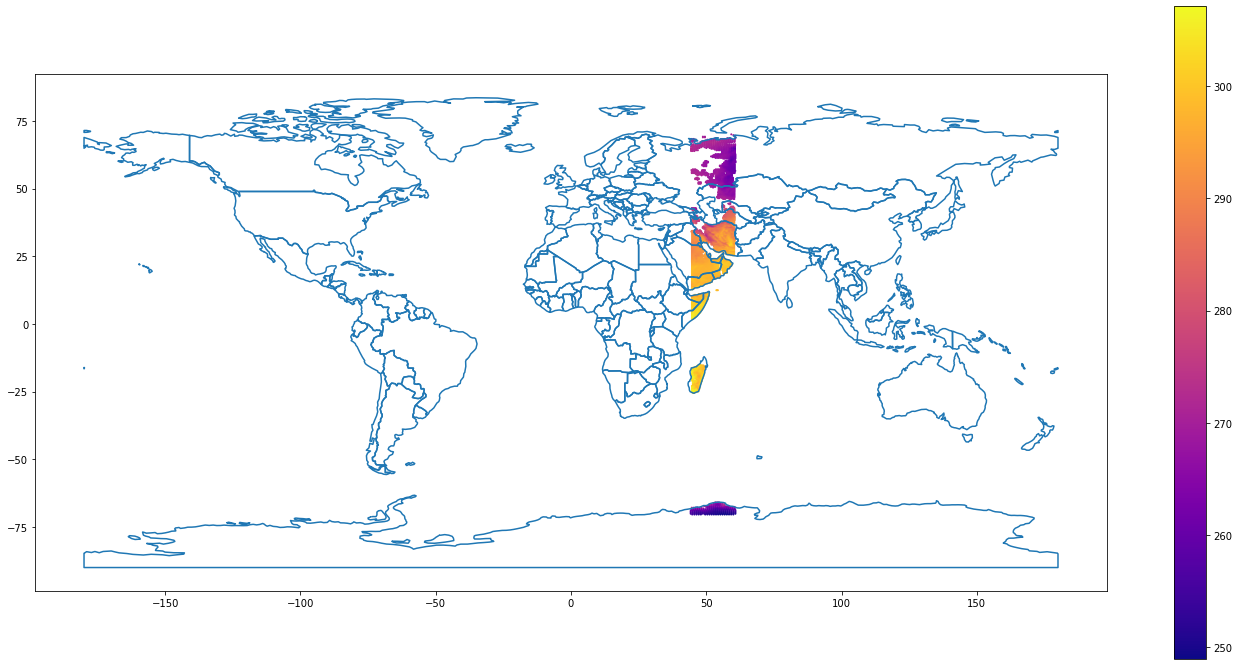

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/joined_ML_data_faiss_swp/aquaDay_2018-01-02_11H_70L_50T.pkl


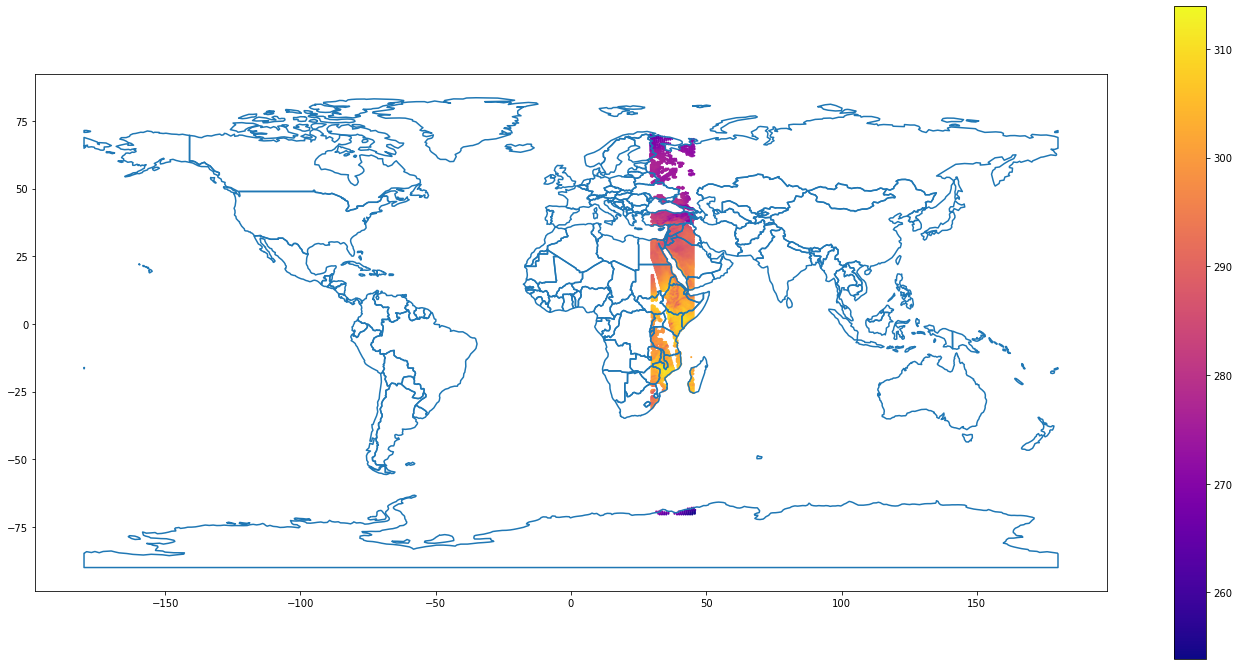

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/joined_ML_data_faiss_swp/aquaDay_2018-01-02_12H_70L_50T.pkl


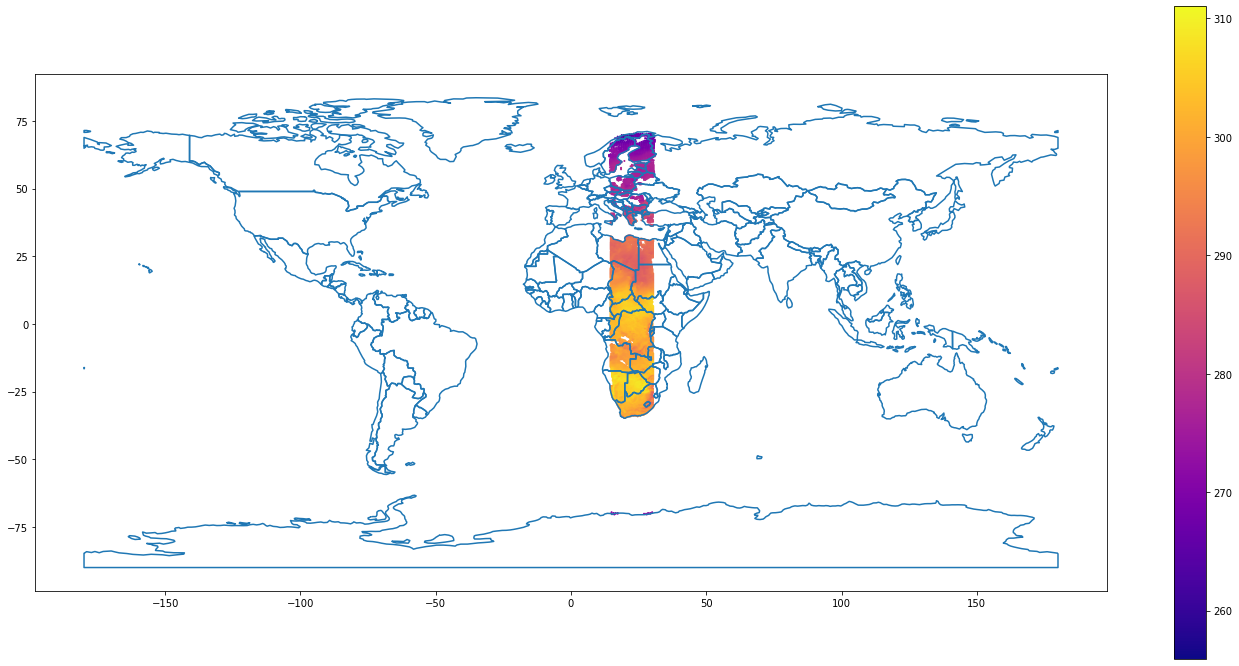

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/joined_ML_data_faiss_swp/aquaDay_2018-01-02_13H_70L_50T.pkl


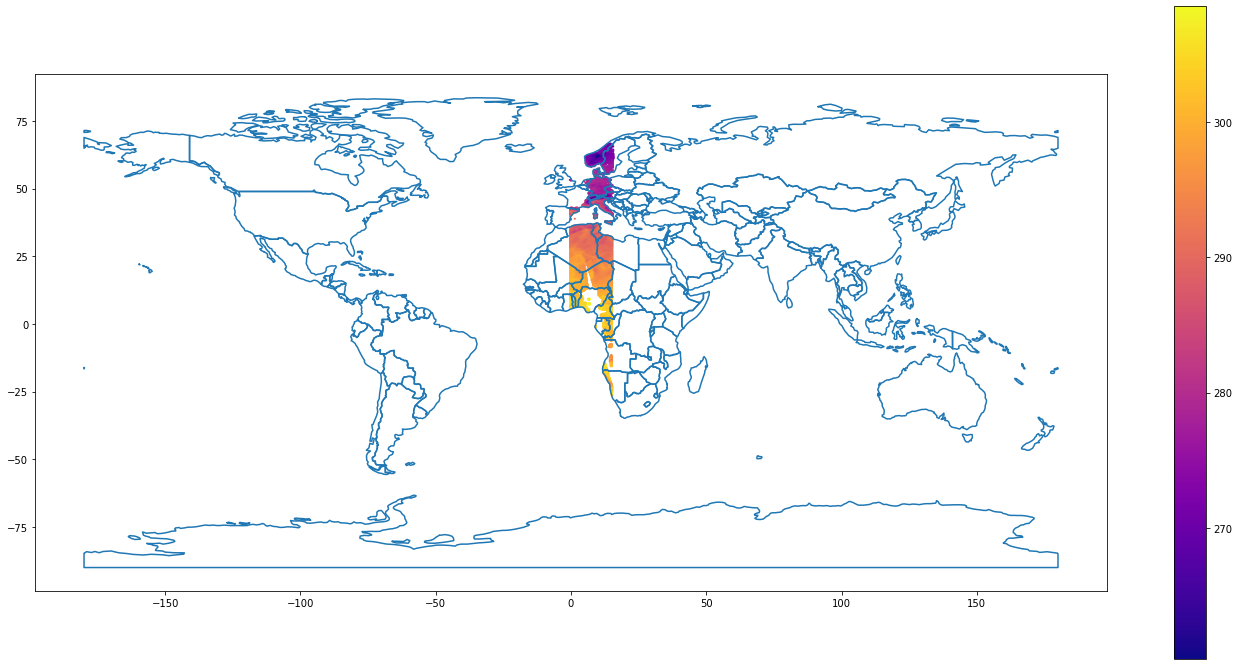

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/joined_ML_data_faiss_swp/aquaDay_2018-01-02_14H_70L_50T.pkl


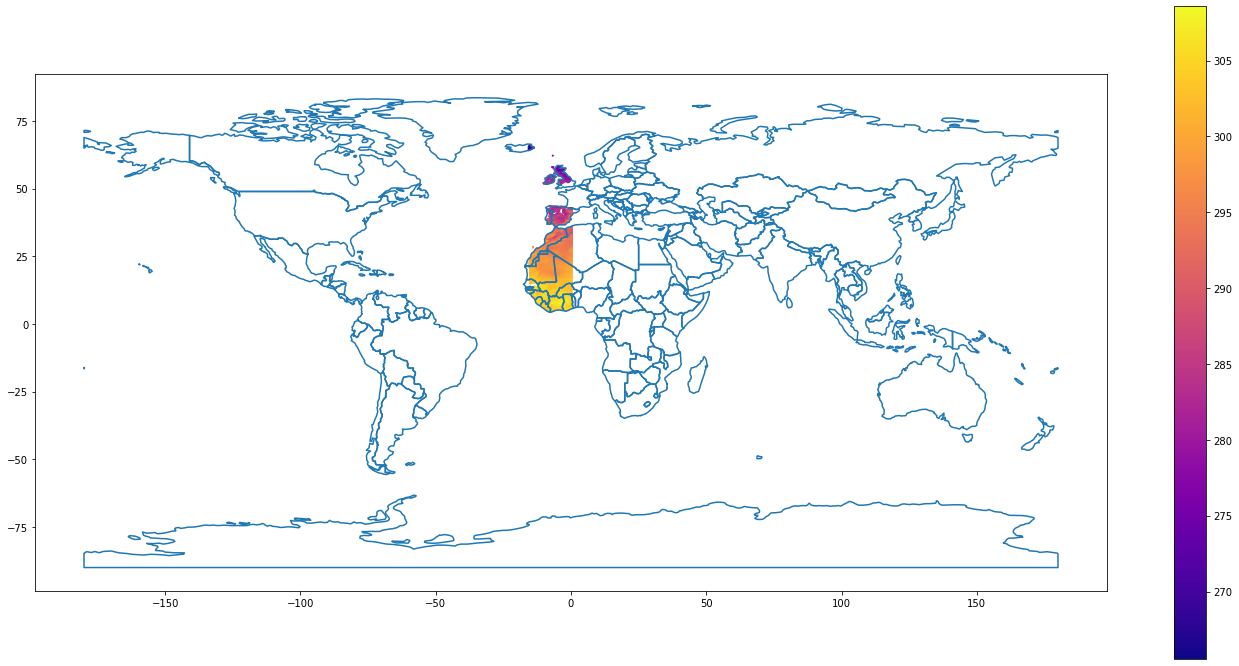

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/joined_ML_data_faiss_swp/aquaDay_2018-01-02_15H_70L_50T.pkl


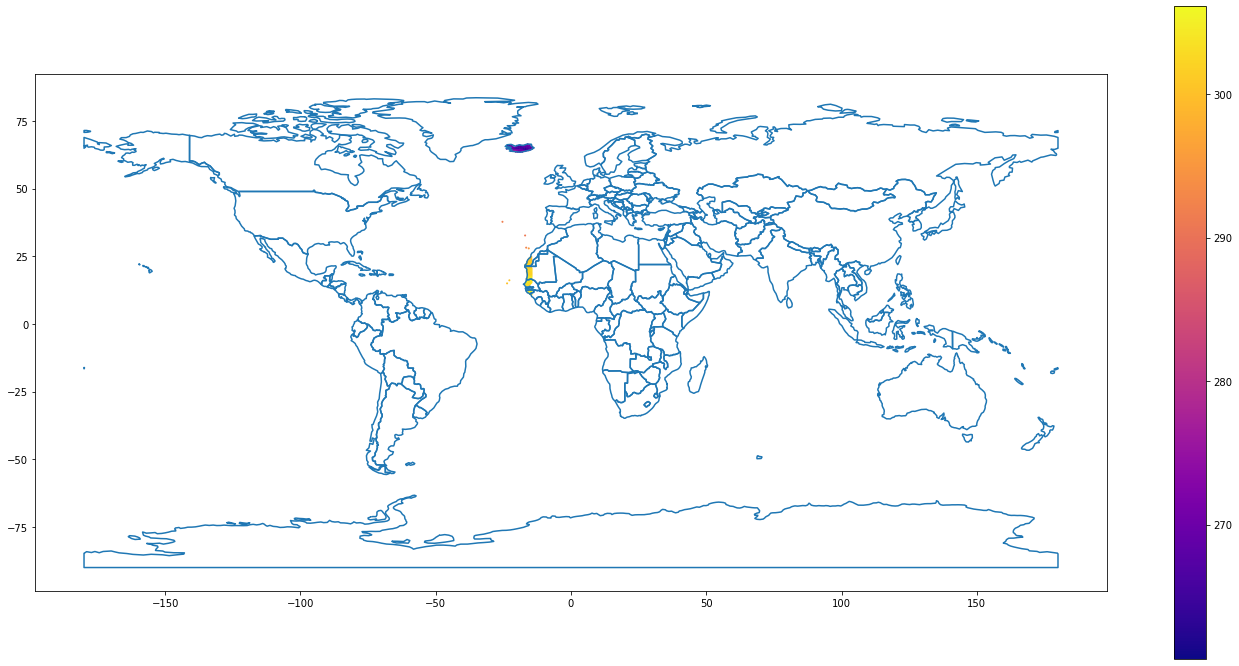

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/joined_ML_data_faiss_swp/aquaDay_2018-01-02_16H_70L_50T.pkl


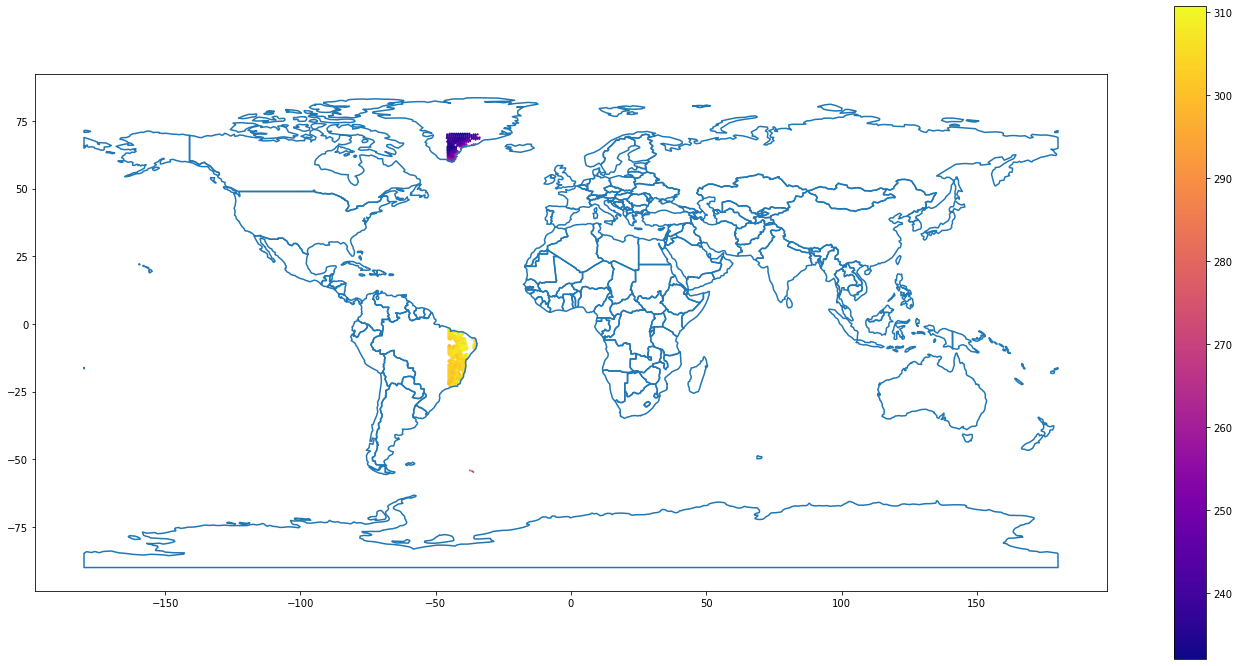

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/joined_ML_data_faiss_swp/aquaDay_2018-01-02_17H_70L_50T.pkl


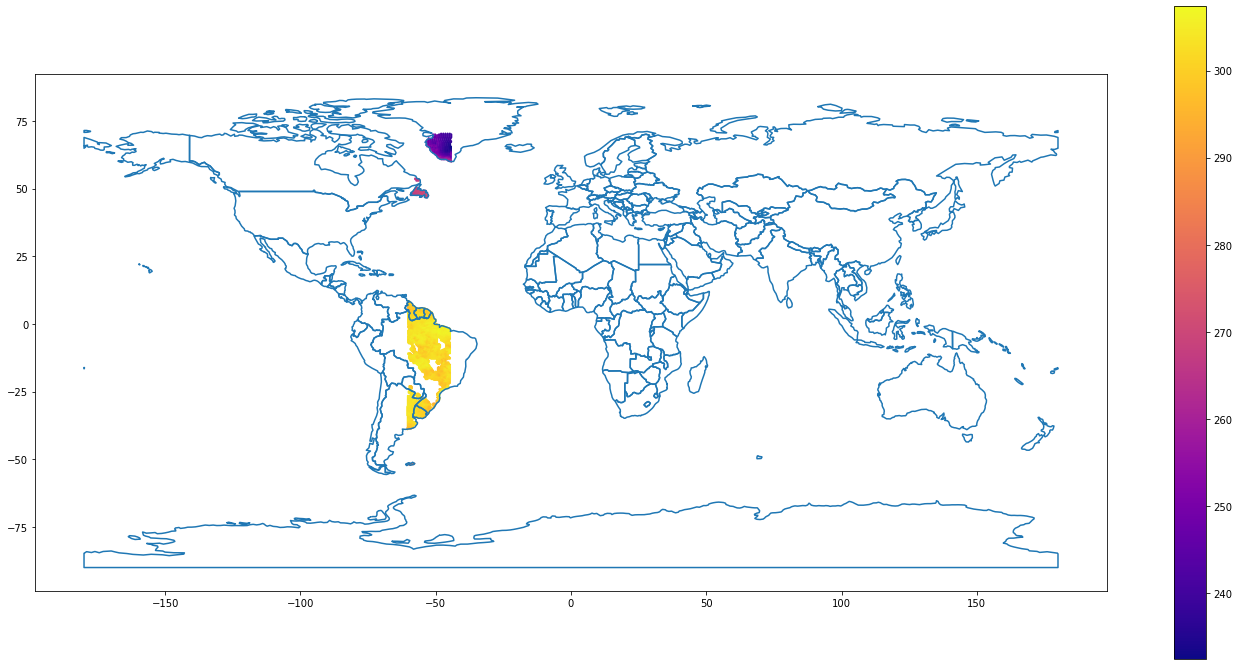

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/joined_ML_data_faiss_swp/aquaDay_2018-01-02_18H_70L_50T.pkl


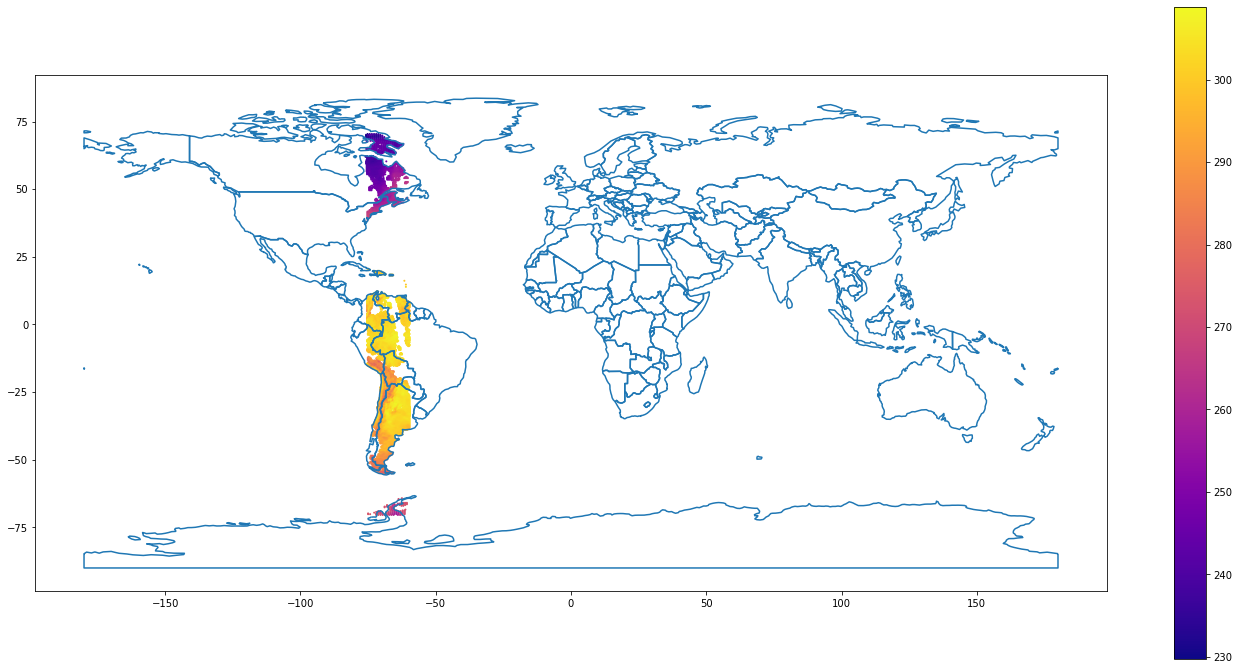

In [3]:
for i in range(1,10):
    f =files[i]
    print(f)
    df = pd.read_pickle(f)
    plot_map(df,'longitude_ERA', 'latitude_ERA', 't2m')

In [4]:
# Time is accidentally dropped during the merge in `Join_MODIS_with_ERA`
# Rather than correct that bug, we can read off time from the file name here
# May be a neater way to do this!

import numpy as np
def read_time(fname):
    
    row = f.split('aquaDay')[-1].split('_')
    d = row[1]
    t = int(row[2].split('H')[0])
    return np.datetime64(f'{d} {t:02}:00:00')

In [5]:
# Now load each file into a single df

dfs = []
for f in files:
    df = pd.read_pickle(f)
    df['time'] = read_time(f)
    dfs.append(df)
    
df = pd.concat(dfs).reset_index()
#and save to disk
df.to_pickle('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS_ERA_joined_data_single.pkl')

# 2. Train the model

In [6]:
import tensorflow as tf



def train_test_split(df,filter_condition,train_condition, test_condition,features,targets):
    
    
    """
    Separate df into a train and test set.
    Returns training and testing dfs as well as split into inputs/outputs 
    """
    
    #Filter dataset
    if filter_condition is not None:
        df_filtered = df.query(filter_condition)
    else:
        df_filtered = df
    
    #Select train/test data
    training_data = df_filtered.query(train_condition)
    test_data     = df_filtered.query(test_condition)
    
    
    #Separate into features/targets

    x_train = training_data[features]
    y_train = training_data[targets]

    x_test = test_data[features]
    y_test = test_data[targets]
    
    
    return x_train,y_train,x_test,y_test,training_data, test_data #
    
    


def create_normalizer_layer(x_train):
    #Create a normaliser layer
    print ('Creating a normalization layer')
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(x_train)
    
    return normalizer

def train_NN(x_train,y_train,normalizer):


    #Check GPU available
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


    #Create a basic NN model
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(int(len(features)/2), activation='relu',input_shape=(len(features),),name='layer1'),
        tf.keras.layers.Dense(1, name='output')
  ])

    #Compile it
    print ('Compiling model')
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['accuracy'])
    

    
    #Train it
    print('Training model')
    history = model.fit(x_train, y_train, epochs=100, batch_size=10000) 
    
    
    return history, model





In [7]:
#Load the df you just created and saved above
df =pd.read_pickle('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS_ERA_joined_data_single.pkl')

In [8]:
#Process input data
filter_condition = None
train_condition = 'time < "2019-01-01 00:00:00"'
test_condition = 'time >= "2020-01-01 00:00:00"'
features = ['sp', 'msl', 'u10', 'v10','t2m',
            'aluvp', 'aluvd', 'alnip', 'alnid', 'cl',
            'cvl', 'cvh', 'slt', 'sdfor', 'z', 'sd', 'sdor', 'isor', 'anor', 'slor',
            'd2m', 'lsm', 'fal'] 

targets = ['MODIS_LST']


x_train,y_train,x_test,y_test,df_train,df_test = train_test_split(df,filter_condition,train_condition, test_condition,features,targets)


In [ ]:
x_train

In [9]:
#Train NN
normalizer = create_normalizer_layer(x_train)
history,model = train_NN(x_train,y_train,normalizer)

#Save trained model and training history
model.save('example_model_single')

import json
history_dict = history.history
json.dump(history_dict, open('history_avg.json', 'w'))

Creating a normalization layer


2022-03-15 15:11:14.585161: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-15 15:11:19.281625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38396 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2022-03-15 15:11:29.132343: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4011109288 exceeds 10% of free system memory.
2022-03-15 15:11:31.555431: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4011109288 exceeds 10% of free system memory.


Num GPUs Available:  1
Compiling model
Training model


2022-03-15 15:23:01.104159: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4011109288 exceeds 10% of free system memory.
2022-03-15 15:23:02.762905: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4011109288 exceeds 10% of free system memory.


Epoch 1/100
  16/4360 [..............................] - ETA: 14s - loss: 88213.7500 - accuracy: 0.0000e+00    

2022-03-15 15:23:10.381975: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4360/4360 [==============================] - 12s 1ms/step - loss: 39129.4258 - accuracy: 0.0000e+00
Epoch 2/100
4360/4360 [==============================] - 6s 1ms/step - loss: 4475.9834 - accuracy: 0.0000e+00
Epoch 3/100
4360/4360 [==============================] - 6s 1ms/step - loss: 699.5244 - accuracy: 0.0000e+00
Epoch 4/100
4360/4360 [==============================] - 7s 2ms/step - loss: 70.7084 - accuracy: 0.0000e+00
Epoch 5/100
4360/4360 [==============================] - 6s 1ms/step - loss: 33.9632 - accuracy: 0.0000e+00
Epoch 6/100
4360/4360 [==============================] - 7s 1ms/step - loss: 30.6780 - accuracy: 0.0000e+00
Epoch 7/100
4360/4360 [==============================] - 7s 2ms/step - loss: 29.9680 - accuracy: 0.0000e+00
Epoch 8/100
4360/4360 [==============================] - 6s 1ms/step - loss: 29.7874 - accuracy: 0.0000e+00
Epoch 9/100
4360/4360 [==============================] - 6s 1ms/step - loss: 29.7115 - accuracy: 0.0000e+00
Epoch 10/100
4360/4360 [=========

2022-03-15 15:33:47.505299: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: example_model_single/assets


# 3. Test and evaluate the model

In [16]:
#Load the trained model
model = tf.keras.models.load_model('example_model_single')

In [17]:
#Make some predictions with your model
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
predictions = model.predict(x_test)

Num GPUs Available:  1
ERROR! Session/line number was not unique in database. History logging moved to new session 420


In [21]:
#Create a results df that holds the test data, the predictions, and the errors
df_results = df_test.copy()
df_results['predict'] = predictions
df_results['error_model'] = abs(df_results.MODIS_LST - df_results.predict)
df_results['error_ERA'] = abs(df_results.MODIS_LST - df_results.t2m)

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


def custom_round(x, base):
    return base * round(float(x)/base)

def plot_error(df,x,grain,show_variance):
    
    
    """
    Plot errors in the NN temperature compared to ERA5
    x is the x axis variable. Typically longitude/latitude or time.
    Grain argument sets the precision as days, months, etc. if variable is time, else an integer for decimal places precision
    show_variance enables plotting confidence intervals using seaborns bootstrapping method.
    For large datasets - like the one we have here! - this is slow, so typically have this off
    """
    
    
    #Some useful numbers
    print("Mean, Median error from NN model:",df.error_model.mean(), df_results.error_model.median())
    print("Mean, Median error from ERA5:    ", df.error_ERA.mean(), df_results.error_ERA.median())


    #Setup the x variable to plot.
    if x == 'time':
        df["X"] = df_results[x].dt.to_period(grain).dt.to_timestamp()
    else:
        df["X"] = df_results[x].round(grain) # Can also use .apply(lambda x: custom_round(x, base=2))
        
    #Group by if needed   
    if show_variance:
        print('You are trying to plot a confdence interval. This could take a few minutes')
        df_plot = df
    else:
        #Group by
        df_plot = df_results.groupby(['X'],as_index=False).mean()
    
    
    #Setup plot env
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    
    
    #Plot
    p = sns.lineplot(data=df_plot, x='X', y='error_model',ax=ax1,markers=True,label='NN')
    p = sns.lineplot(data=df_plot, x='X', y='error_ERA',ax=ax1,markers=True,label='ERA')
    
    #Config
    ax1.set_xlabel(f'{x}, grain: {grain}', fontsize = 20)
    ax1.set_ylabel('Error [K]', fontsize = 20)


    

    #Other config
    ax1.legend().set_title(None)

Mean, Median error from NN model: 3.9521587 3.0278625
Mean, Median error from ERA5:     6.749548 5.006134
CPU times: user 3.45 s, sys: 3min 53s, total: 3min 57s
Wall time: 4min 4s


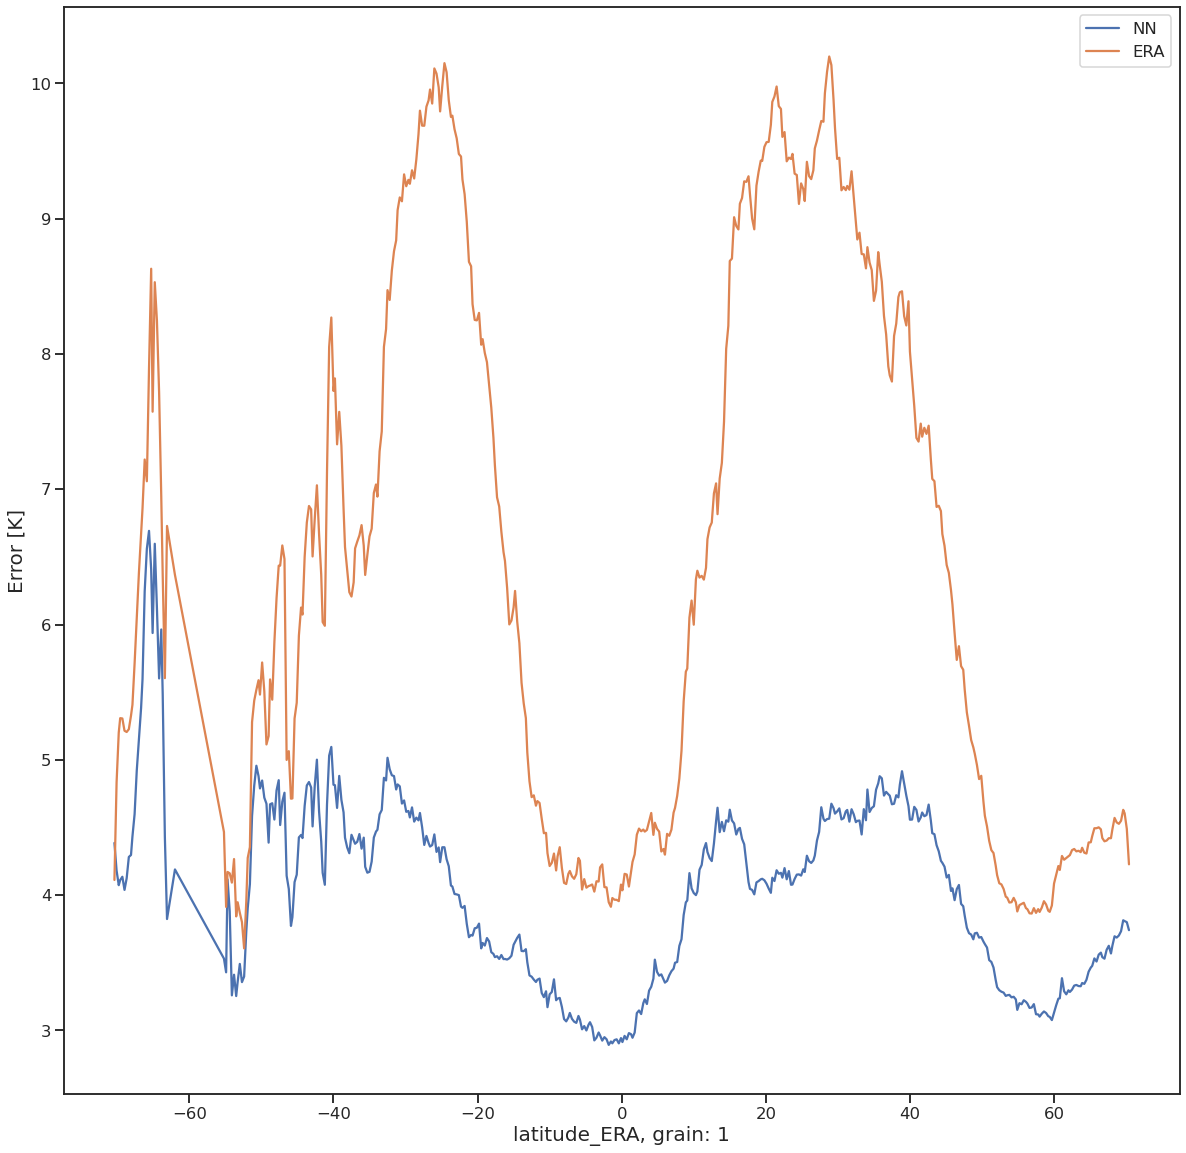

In [23]:
%%time
plot_error(df_results,x='latitude_ERA',grain=1, show_variance=False)

Mean, Median error from NN model: 3.9521587 3.0278625
Mean, Median error from ERA5:     6.749548 5.006134
CPU times: user 11.3 s, sys: 4.95 s, total: 16.2 s
Wall time: 16.4 s


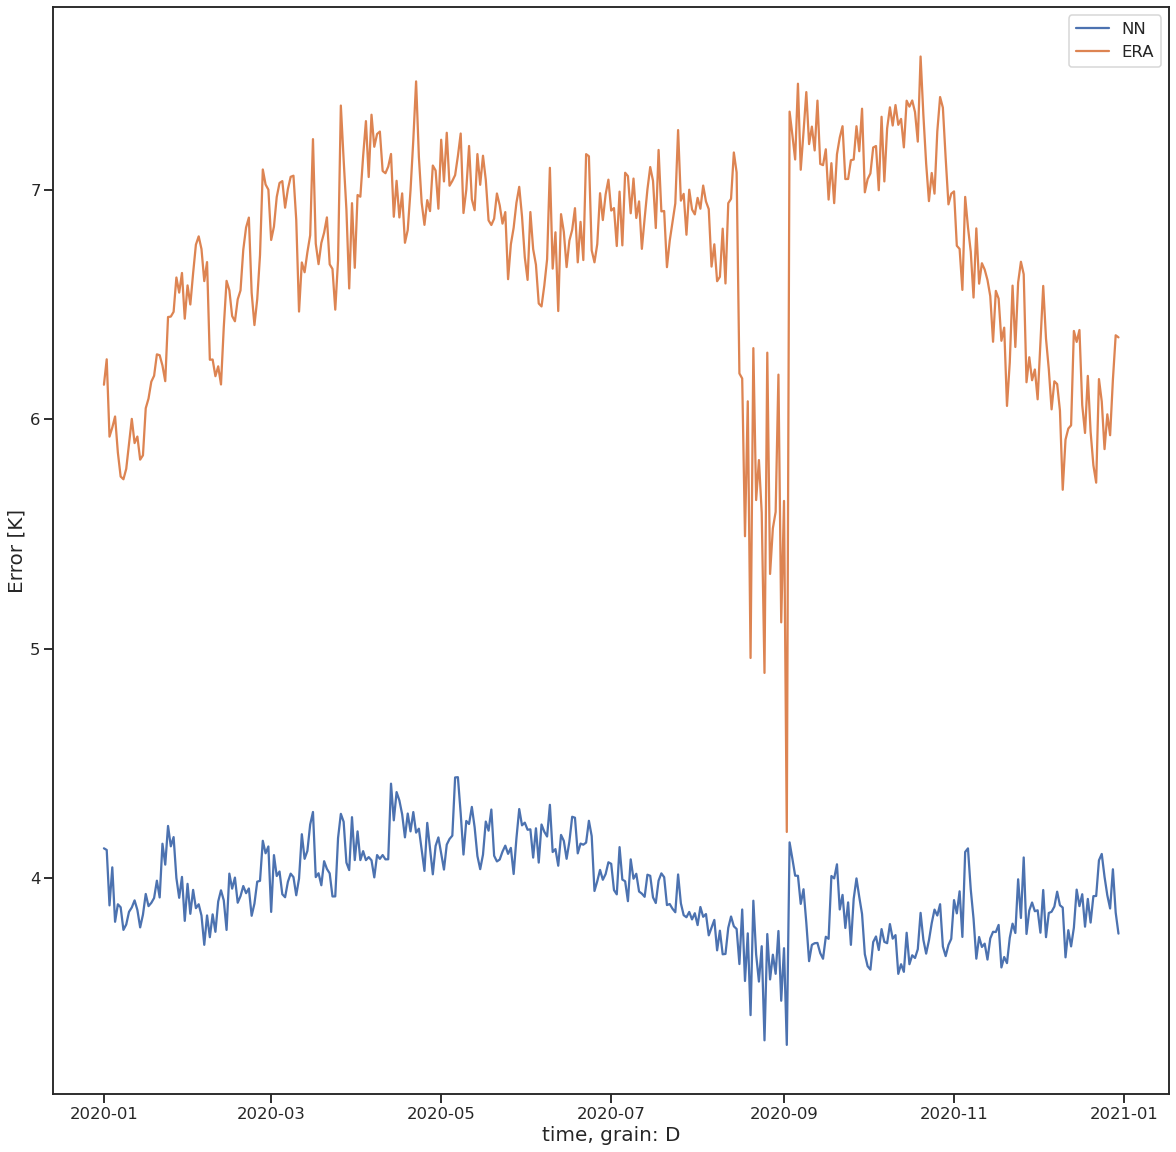

In [24]:
%%time
plot_error(df_results,x='time',grain="D", show_variance=False)